# Segmentez des clients d'un site e-commerce - Exploration

Pascaline Grondein

Début : 30/05/2022

<i/> Vous êtes consultant pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne. </i>

<i/> Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

<i/>Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

<i/>Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.</i>

### Table of Contents

* [I. Exploration des données](#chapter1)
    * [1. Customers](#section_1_1)
    * [2. Geolocation](#section_1_2)
    * [3. Items](#section_1_3)
    * [4. Orders](#section_1_4)
    * [5. Reviews](#section_1_5)
    * [6. Payments](#section_1_6)
    * [7. Products](#section_1_7)
    * [8. Sellers](#section_1_8)
* [II. Formation dataset](#chapter2)
* [III. Préparation des données](#chapter3)
    * [1. RFM](#section_3_1)
    * [2. Subset ++](#section_3_2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statistics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from datetime import datetime
today = datetime.now()

from scipy.stats import pearsonr

import csv
import itertools

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
cat_name_translation = pd.read_csv('product_category_name_translation.csv')

# Fonctions

In [3]:
def def_pd(df, df_name) :
    
    
    #VALEURS MANQUANTES
    #Calcul du pct de valeurs manquantes total
    row = df.shape[0]
    col = df.shape[1]
    nb_val = row * col
    nb_val_manqu = df.isnull().sum().sum()
    val_manq_pct = round((nb_val_manqu/nb_val)*100, 3)
    
    #Calcul du pourcentage de valeurs manquantes par variables
    index = df.index
    nb_na = df.isnull().sum()
    pct_remplissage = pd.DataFrame((100 - ((nb_na/len(index))*100)).astype(int), 
                                   columns = ['Pourcentage de remplissage (%)'])
    display(pct_remplissage)
    
    print('Le fichier {} comporte {} lignes et {} colonnes,' 
          ' ainsi que {} valeurs manquantes sur {} entrées ({} %).'.format(df_name, row,
                                                                           col, nb_val_manqu, nb_val, val_manq_pct))
    #DOUBLONS
    dup = df.loc[df.duplicated(keep=False), :]
    print('Le dataframe comporte', len(dup), 'doublons.')
    
    if len(dup) != 0:
        df = df.drop_duplicates()
    
    
    
    display(df.dtypes)
    display(df.describe(include ='all'))
    

In [4]:
def compare_list(l1,l2):
    
    l1 = list(l1).sort
    l2 = list(l2).sort
        
    if(l1 == l2):
        return "Equal"
    else:
        return "Non equal"

In [5]:
def boxplot(df):
    
    boxprops = dict(linestyle='-', linewidth=1, color='k')
    medianprops = dict(linestyle='-', linewidth=1, color='k')
    meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
    sns.set_style("whitegrid")

    num_ = list(df._get_numeric_data())

    for col in num_ :
    
        plt.figure(figsize=(10, 8))
    
        df.boxplot(column=col, boxprops = boxprops, showfliers=True, 
                   medianprops=medianprops, vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
        plt.title(col, fontsize = 30)
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.xlabel('', fontsize = 25)
        plt.ylabel('', fontsize = 25)

    plt.show()

In [6]:
def pie(df, var, lim):
    
    
    df_plot = pd.DataFrame(df[var].value_counts(normalize = True))
    df_plot = df_plot.rename(columns = {var :'Frequence' })
    df_plot_1 = df_plot.loc[df_plot['Frequence'] > lim]
    
    plot = df_plot_1.plot(kind='pie', y = 'Frequence', autopct ='%1.0f%%', figsize=(10, 10), 
                          fontsize = 25, legend = False, labeldistance = 1.1)
                                                     

    plot.set_title(var,fontsize = 40)
    plt.title(var,fontsize = 30)
    plt.xlabel('')
    plt.ylabel('')
    plt.axis('equal') 
    plt.show()
    
    pct = pd.DataFrame(data = df[var].value_counts()).rename(columns = {var :'Nb Users' })
    pct['% users'] = (pct['Nb Users']/len(df))*100
    
    display(pct)

In [7]:
def barplot(df, var):
    
    plt.figure(figsize = (10, 6))
    
    df[var].value_counts().plot(kind='bar', width=0.5)
    plt.title(var, fontsize = 30)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xlabel('', fontsize = 25)
    plt.ylabel('', fontsize = 25)
    
    plt.show()

In [8]:
def histo(df, var, b, cumulative, x, y):

    plt.figure(figsize = (10, 6))
    
    if cumulative == 1 :
        df[var].value_counts().hist(density = True, bins=b, cumulative = -1)
    else :
        df[var].value_counts().hist(density = True, bins=b, cumulative = False)
        
    plt.xlim(0, x)
    plt.ylim(0, y)
    plt.title(var,fontsize = 30)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xlabel('', fontsize = 25)
    plt.ylabel('', fontsize = 25)

    plt.show()

In [9]:
def correlation(df):
    
    sns.set_theme(style="white")
    plt.figure(figsize = (15, 13))
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.set(font_scale = 1.5)
    sns.heatmap(corr, mask = mask, annot = True, fmt = '.2g', cmap = cmap, 
                vmax = .9, vmin = -0.9, center=0, square = True, linewidths = .5, cbar_kws = {"shrink": .5})

    plt.show()
    return corr

# <a class="anchor" id="chapter1">I. Exploration des données </a>

## <a class="anchor" id="section_1_1">1. Customers</a> 

In [10]:
def_pd(customers, 'Customers')

,Pourcentage de remplissage (%)
customer_id,100
customer_unique_id,100
customer_zip_code_prefix,100
customer_city,100
customer_state,100


Le fichier Customers comporte 99441 lignes et 5 colonnes, ainsi que 0 valeurs manquantes sur 497205 entrées (0.0 %).
Le dataframe comporte 0 doublons.


customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441.000000,99441,99441
unique,99441,96096,NaN,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,NaN,sao paulo,SP
freq,1,17,NaN,15540,41746
mean,NaN,NaN,35137.474583,NaN,NaN
std,NaN,NaN,29797.938996,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11347.000000,NaN,NaN
50%,NaN,NaN,24416.000000,NaN,NaN
75%,NaN,NaN,58900.000000,NaN,NaN


Définition variables : 
 - customer_id : key to the orders dataset. Each order has a unique customer_id.
 - customer_unique_id : unique identifier of a customer.
 - customer_zip_code_prefix: first five digits of customer zip code
 - customer_city : customer city name
 - customer_state : customer state

Variables pertinentes : 
 - customer_id : pour le lien avec order_id
 - customer_unique_id : variable principale pour les clients ==> index
 - customer_state

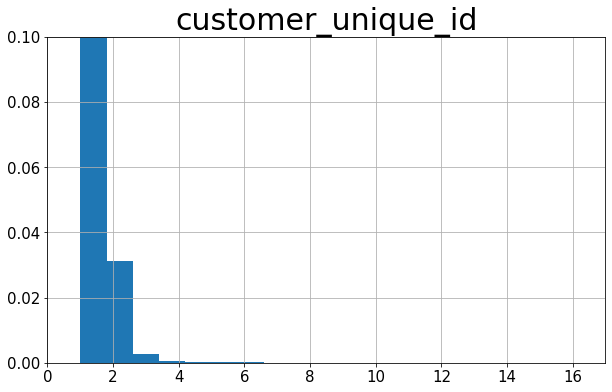

In [11]:
histo(customers, 'customer_unique_id', b = 20, cumulative = 1, x = 17, y = 0.1)

In [12]:
customer_var = ['customer_id', 'customer_unique_id', 'customer_state']
customer_subset = customers[customer_var]

## <a class="anchor" id="section_1_2">2. Geolocation</a> 

In [13]:
def_pd(geolocation, 'Geolocation')

,Pourcentage de remplissage (%)
geolocation_zip_code_prefix,100
geolocation_lat,100
geolocation_lng,100
geolocation_city,100
geolocation_state,100


Le fichier Geolocation comporte 1000163 lignes et 5 colonnes, ainsi que 0 valeurs manquantes sur 5000815 entrées (0.0 %).
Le dataframe comporte 390005 doublons.


geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
count,738332.000000,738332.000000,738332.000000,738332,738332
unique,NaN,NaN,NaN,8011,27
top,NaN,NaN,NaN,sao paulo,SP
freq,NaN,NaN,NaN,79927,285976
mean,38316.086800,-20.998353,-46.461098,NaN,NaN
std,30632.496675,5.892315,4.393705,NaN,NaN
min,1001.000000,-36.605374,-101.466766,NaN,NaN
25%,12600.000000,-23.603061,-48.867822,NaN,NaN
50%,29144.000000,-22.873588,-46.647278,NaN,NaN
75%,65950.000000,-19.923336,-43.836974,NaN,NaN


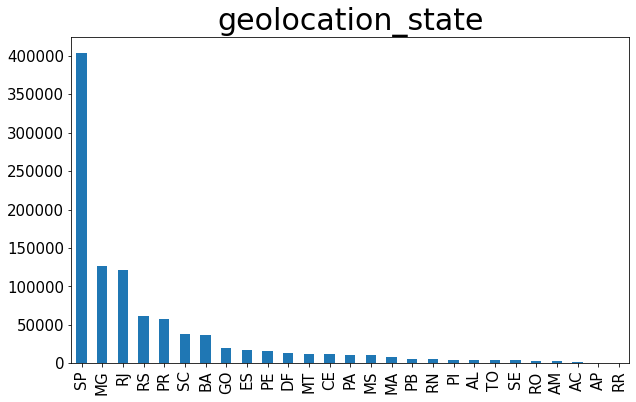

In [14]:
barplot(geolocation, 'geolocation_state')

## <a class="anchor" id="section_1_3">3. Items</a> 

In [15]:
def_pd(order_items, 'Order Items')

,Pourcentage de remplissage (%)
order_id,100
order_item_id,100
product_id,100
seller_id,100
shipping_limit_date,100
price,100
freight_value,100


Le fichier Order Items comporte 112650 lignes et 7 colonnes, ainsi que 0 valeurs manquantes sur 788550 entrées (0.0 %).
Le dataframe comporte 0 doublons.


order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650,112650,112650,112650.000000,112650.000000
unique,98666,NaN,32951,3095,93318,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23,NaN,NaN
freq,21,NaN,527,2033,21,NaN,NaN
mean,NaN,1.197834,NaN,NaN,NaN,120.653739,19.990320
std,NaN,0.705124,NaN,NaN,NaN,183.633928,15.806405
min,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000
25%,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000
50%,NaN,1.000000,NaN,NaN,NaN,74.990000,16.260000
75%,NaN,1.000000,NaN,NaN,NaN,134.900000,21.150000


Définition variables : 
 - order_id : order unique identifier
 - order_item_id : sequential number identifying number of items included in the same order
 - product_id : product unique identifier
 - seller_id : seller unique identifier
 - shipping_limit_date : Shows the seller shipping limit date for handling the order over to the logistic partner
 - price : item price
 - freight_value : item freight value item (if an order has more than one item the freight value is splitted between items)

Variables pertinentes : 
 - order_id
 - order_item_id

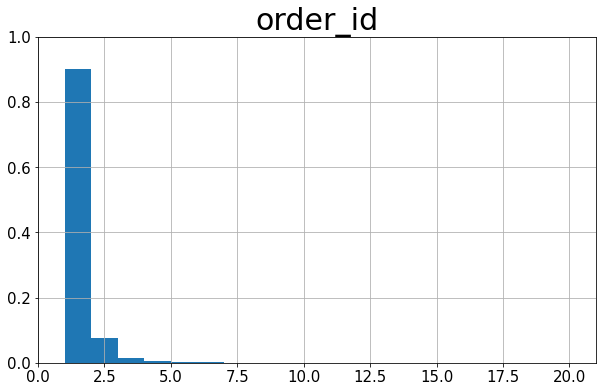

In [16]:
histo(order_items, 'order_id', b = 20, cumulative = 0, x = 21, y = 1)

In [17]:
items_var = ['order_id', 'order_item_id']
item_subset = order_items[items_var]
#calcul du nb moyen d'item par commande
item_subset = item_subset.groupby(by = ['order_id'], axis = 0, as_index = False).mean() 

## <a class="anchor" id="section_1_4">4. Orders</a>  

In [18]:
def_pd(orders, 'Orders')

,Pourcentage de remplissage (%)
order_id,100
customer_id,100
order_status,100
order_purchase_timestamp,100
order_approved_at,99
order_delivered_carrier_date,98
order_delivered_customer_date,97
order_estimated_delivery_date,100


Le fichier Orders comporte 99441 lignes et 8 colonnes, ainsi que 4908 valeurs manquantes sur 795528 entrées (0.617 %).
Le dataframe comporte 0 doublons.


order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


In [19]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
dtype: object

In [20]:
date_ref = max(orders['order_purchase_timestamp'])

Définition variables :
 - order_id : unique identifier of the order.
 - customer_id : key to the customer dataset. Each order has a unique customer_id
 - order_status : Reference to the order status (delivered, shipped, etc)
 - order_purchase_timestamp : Shows the purchase timestamp
 - order_approved_at : Shows the payment approval timestamp
 - order_delivered_carrier_date : Shows the order posting timestamp. When it was handled to the logistic partner
 - order_delivered_customer_date : Shows the actual order delivery date to the customer
 - order_estimated_delivery_date : Shows the estimated delivery date that was informed to customer at the purchase moment

Variables pertinentes : 

 - order_id
 - customer_id
 - order_purchase_timestamp

In [21]:
order_var = ['order_id', 'customer_id', 'order_purchase_timestamp']
order_subset = orders[order_var]

## <a class="anchor" id="section_1_5">5. Reviews</a>  

In [22]:
def_pd(order_reviews, 'Order Reviews')

,Pourcentage de remplissage (%)
review_id,100
order_id,100
review_score,100
review_comment_title,11
review_comment_message,41
review_creation_date,100
review_answer_timestamp,100


Le fichier Order Reviews comporte 99224 lignes et 7 colonnes, ainsi que 145903 valeurs manquantes sur 694568 entrées (21.006 %).
Le dataframe comporte 0 doublons.


review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,99224,99224,99224.000000,11568,40977,99224,99224
unique,98410,98673,NaN,4527,36159,636,98248
top,7b606b0d57b078384f0b58eac1d41d78,c88b1d1b157a9999ce368f218a407141,NaN,Recomendo,Muito bom,2017-12-19 00:00:00,2017-06-15 23:21:05
freq,3,3,NaN,423,230,463,4
mean,NaN,NaN,4.086421,NaN,NaN,NaN,NaN
std,NaN,NaN,1.347579,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN


Définition variables : 
 - review_id : unique review identifier
 - order_id : unique order identifier
 - review_score : Note ranging from 1 to 5 given by the customer on a satisfaction survey.
 - review_comment_title : Comment title from the review left by the customer, in Portuguese
 - review_comment_message : Comment message from the review left by the customer, in Portuguese
 - review_creation_date : Shows the date in which the satisfaction survey was sent to the customer
 - review_answer_timestamp : Shows satisfaction survey answer timestamp

Variables intéressantes : 
    
 - order_id
 - review_score

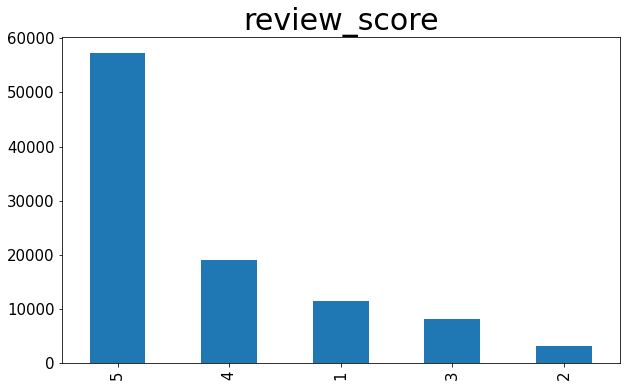

In [23]:
barplot(order_reviews, 'review_score')

In [24]:
review_var = ['order_id', 'review_score']
review_subset = order_reviews[review_var]
review_subset = review_subset.groupby(by = ['order_id'], axis = 0, as_index = False).mean()

## <a class="anchor" id="section_1_6">6. Payments</a> 

In [25]:
def_pd(order_payments, 'Order Payments')

,Pourcentage de remplissage (%)
order_id,100
payment_sequential,100
payment_type,100
payment_installments,100
payment_value,100


Le fichier Order Payments comporte 103886 lignes et 5 colonnes, ainsi que 0 valeurs manquantes sur 519430 entrées (0.0 %).
Le dataframe comporte 0 doublons.


order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object

,order_id,payment_sequential,payment_type,payment_installments,payment_value
count,103886,103886.000000,103886,103886.000000,103886.000000
unique,99440,NaN,5,NaN,NaN
top,fa65dad1b0e818e3ccc5cb0e39231352,NaN,credit_card,NaN,NaN
freq,29,NaN,76795,NaN,NaN
mean,NaN,1.092679,NaN,2.853349,154.100380
std,NaN,0.706584,NaN,2.687051,217.494064
min,NaN,1.000000,NaN,0.000000,0.000000
25%,NaN,1.000000,NaN,1.000000,56.790000
50%,NaN,1.000000,NaN,1.000000,100.000000
75%,NaN,1.000000,NaN,4.000000,171.837500


Définition variables : 
- order_id : unique identifier of an order
- payment_sequential : a customer may pay an order with more than one payment method. If he does so, a sequence will be created to 
- payment_type : method of payment chosen by the customer
- payment_installments : number of installments chosen by the customer
- payment_value : transaction value.

Variables pertinentes : 

 - order_id
 - payment_value

In [26]:
payment_var = ['order_id', 'payment_value']
payment_subset = order_payments[payment_var]
payment_subset = payment_subset.groupby(by = ['order_id'], axis = 0, as_index = False).sum()
#payment_subset

##  <a class="anchor" id="section_1_7">7. Products</a> 

In [27]:
def_pd(products, 'Products')

,Pourcentage de remplissage (%)
product_id,100
product_category_name,98
product_name_lenght,98
product_description_lenght,98
product_photos_qty,98
product_weight_g,99
product_length_cm,99
product_height_cm,99
product_width_cm,99


Le fichier Products comporte 32951 lignes et 9 colonnes, ainsi que 2448 valeurs manquantes sur 296559 entrées (0.825 %).
Le dataframe comporte 0 doublons.


product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951,32341,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
unique,32951,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1e9e8ef04dbcff4541ed26657ea517e5,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,NaN,NaN,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,NaN,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,NaN,NaN,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,NaN,NaN,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,NaN,NaN,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000


In [28]:
def_pd(cat_name_translation, 'Translation')

,Pourcentage de remplissage (%)
product_category_name,100
product_category_name_english,100


Le fichier Translation comporte 71 lignes et 2 colonnes, ainsi que 0 valeurs manquantes sur 142 entrées (0.0 %).
Le dataframe comporte 0 doublons.


product_category_name            object
product_category_name_english    object
dtype: object

,product_category_name,product_category_name_english
count,71,71
unique,71,71
top,beleza_saude,health_beauty
freq,1,1


## <a class="anchor" id="section_1_8">8. Sellers</a> 

In [29]:
def_pd(sellers, 'Sellers')

,Pourcentage de remplissage (%)
seller_id,100
seller_zip_code_prefix,100
seller_city,100
seller_state,100


Le fichier Sellers comporte 3095 lignes et 4 colonnes, ainsi que 0 valeurs manquantes sur 12380 entrées (0.0 %).
Le dataframe comporte 0 doublons.


seller_id                 object
seller_zip_code_prefix     int64
seller_city               object
seller_state              object
dtype: object

,seller_id,seller_zip_code_prefix,seller_city,seller_state
count,3095,3095.000000,3095,3095
unique,3095,NaN,611,23
top,3442f8959a84dea7ee197c632cb2df15,NaN,sao paulo,SP
freq,1,NaN,694,1849
mean,NaN,32291.059451,NaN,NaN
std,NaN,32713.453830,NaN,NaN
min,NaN,1001.000000,NaN,NaN
25%,NaN,7093.500000,NaN,NaN
50%,NaN,14940.000000,NaN,NaN
75%,NaN,64552.500000,NaN,NaN


# <a class="anchor" id="chapter2">II. Formation dataset</a>

On fusionne déjà par order_id, puis on crée les variables utiles pour nous et on enlève celles non pertinentes :

In [30]:
ds1 = customer_subset.merge(order_subset, on = 'customer_id')
#ds1

In [31]:
ds2 = ds1.merge(item_subset, on = 'order_id')
#ds2

In [32]:
ds3 = ds2.merge(review_subset, on = 'order_id') 
#ds3

In [33]:
ds4 = ds3.merge(payment_subset, on = 'order_id') 
#ds4

In [34]:
ds4.describe(include = 'all')

,customer_id,customer_unique_id,customer_state,order_id,order_purchase_timestamp,order_item_id,review_score,payment_value
count,97916,97916,97916,97916,97916,97916.000000,97916.000000,97916.000000
unique,97916,94720,27,97916,97370,NaN,NaN,NaN
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,SP,00e7ee1b050b8499577073aeb2a297a1,2018-04-11 10:48:14,NaN,NaN,NaN
freq,1,16,41108,1,3,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,2016-09-04 21:15:19,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2018-09-03 09:06:57,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.070412,4.105087,160.367686
std,NaN,NaN,NaN,NaN,NaN,0.266876,1.330286,219.286727
min,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,9.590000
25%,NaN,NaN,NaN,NaN,NaN,1.000000,4.000000,61.930000


In [35]:
data = ds4
data.to_csv('data.csv')

In [36]:
order_review = ds4.groupby(by = ['customer_unique_id'], axis = 0, as_index = False).mean()
order_review = order_review.set_index('customer_unique_id')
order_review = order_review.rename(columns = {'payment_value' : 'Average_Basket', 
                                              'order_item_id' : 'Average_nb_items', 
                                              'review_score' : 'Review_score'})
order_review['Average_nb_items'] = round(order_review['Average_nb_items'])
order_review['Review_score'] = round(order_review['Review_score'], 1)
#order_review

In [37]:
total_payment = ds4[['customer_unique_id', 'payment_value', 'order_item_id']]
total_payment = total_payment.groupby(by = ['customer_unique_id'], axis = 0, as_index = False).sum()
total_payment = total_payment.rename(columns = {'payment_value' : 'Montant', 'order_item_id' : 'Total_nb_items'})
total_payment = total_payment.set_index('customer_unique_id')
#total_payment

In [38]:
nb_order = pd.DataFrame(ds4['customer_unique_id'].value_counts())
nb_order = nb_order.rename(columns = {'customer_unique_id' : 'Frequence' })
#nb_order

In [39]:
day_bet_order = ds4[['customer_unique_id', 'order_purchase_timestamp']]
betw_order = pd.DataFrame(columns = ['customer_unique_id', 'Days_bet_orders'])

for cust in day_bet_order['customer_unique_id'].unique() :
    
    dates = list(day_bet_order.loc[day_bet_order['customer_unique_id'] == cust, 'order_purchase_timestamp'])
    nb_dates = len(dates)
    
    if nb_dates == 1 :
        
        #diff = (abs(dates[0] - today).days + 1)
        betw_order = betw_order.append({'customer_unique_id' : cust, 'Days_bet_orders' : 0},
                                       ignore_index = True)
    if nb_dates > 1 :
        
        sorted(dates)
        interval = []
        
        for i in range(nb_dates) :
            
            diff = abs(dates[i] - dates[i-1]).days
            interval.append(diff)
            
        moy = statistics.mean(interval)
        betw_order = betw_order.append({'customer_unique_id' : cust, 'Days_bet_orders' : (moy + 1)},
                                       ignore_index=True)
            
betw_order = betw_order.set_index('customer_unique_id')
betw_order = betw_order.astype({'Days_bet_orders' : 'int'})
max_days = betw_order['Days_bet_orders'].max()
betw_order = betw_order.replace(to_replace = 0, value = max_days + 1)
#betw_order

In [40]:
ds4 = ds4.drop(['customer_id', 'payment_value', 'order_item_id', 'review_score'], axis = 1)
ds4 = ds4.sort_values(by = 'order_purchase_timestamp', axis = 0 , ascending = False)
ds4 = ds4.drop_duplicates(subset = ['customer_unique_id'])
ds4['Recence'] = (date_ref - ds4['order_purchase_timestamp']).dt.days
ds4 = ds4.set_index('customer_unique_id')
ds4 = pd.concat([ds4, nb_order, order_review, betw_order, total_payment], axis = 1)
def_pd(ds4, 'data')

,Pourcentage de remplissage (%)
customer_state,100
order_id,100
order_purchase_timestamp,100
Recence,100
Frequence,100
Average_nb_items,100
Review_score,100
Average_Basket,100
Days_bet_orders,100
Montant,100


Le fichier data comporte 94720 lignes et 11 colonnes, ainsi que 0 valeurs manquantes sur 1041920 entrées (0.0 %).
Le dataframe comporte 0 doublons.


customer_state                      object
order_id                            object
order_purchase_timestamp    datetime64[ns]
Recence                              int64
Frequence                            int64
Average_nb_items                   float64
Review_score                       float64
Average_Basket                     float64
Days_bet_orders                      int32
Montant                            float64
Total_nb_items                     float64
dtype: object

,customer_state,order_id,order_purchase_timestamp,Recence,Frequence,Average_nb_items,Review_score,Average_Basket,Days_bet_orders,Montant,Total_nb_items
count,94720,94720,94720,94720.000000,94720.000000,94720.000000,94720.000000,94720.000000,94720.000000,94720.000000,94720.000000
unique,27,94720,94464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,SP,54282e97f61c23b78330c15b154c867d,2017-11-20 11:46:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,39721,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2016-09-04 21:15:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2018-09-03 09:06:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,286.965783,1.033742,1.103473,4.102532,160.829612,594.059692,165.778740,1.106530
std,NaN,NaN,NaN,153.160973,0.210529,0.341168,1.326361,219.979710,92.198133,227.126785,0.366722
min,NaN,NaN,NaN,44.000000,1.000000,1.000000,1.000000,9.590000,1.000000,9.590000,1.000000
25%,NaN,NaN,NaN,163.000000,1.000000,1.000000,4.000000,62.390000,610.000000,63.100000,1.000000


# <a class="anchor" id="chapter3">III. Préparation des données</a> 

In [41]:
data = ds4

## <a class="anchor" id="section_3_1">1. RFM subset</a> 

In [42]:
RFM_subset = data[['Recence', 'Frequence', 'Montant']]
RFM_subset.to_csv('RFM_subset.csv')

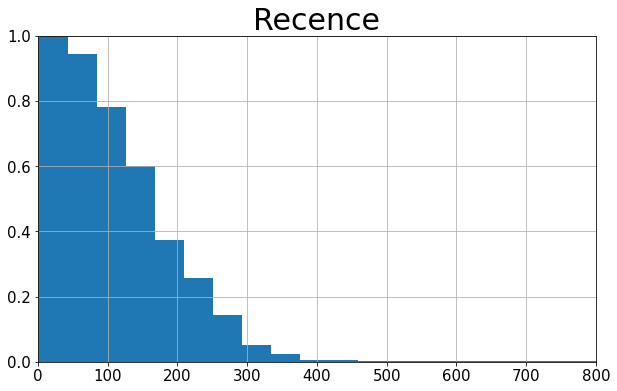

In [43]:
histo(RFM_subset, 'Recence', b = 20, cumulative = 1, x = 800, y = 1)

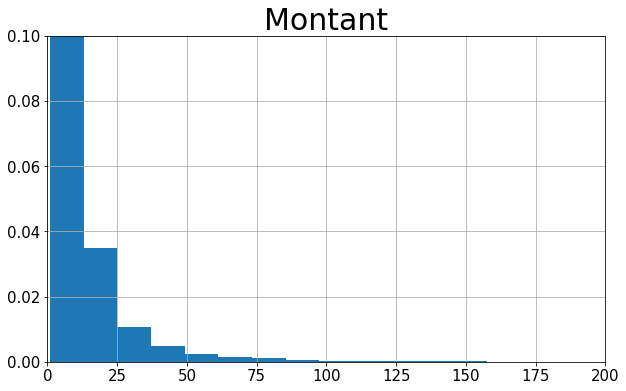

In [44]:
histo(RFM_subset, 'Montant', b = 20, cumulative = 1, x = 200, y = 0.1)

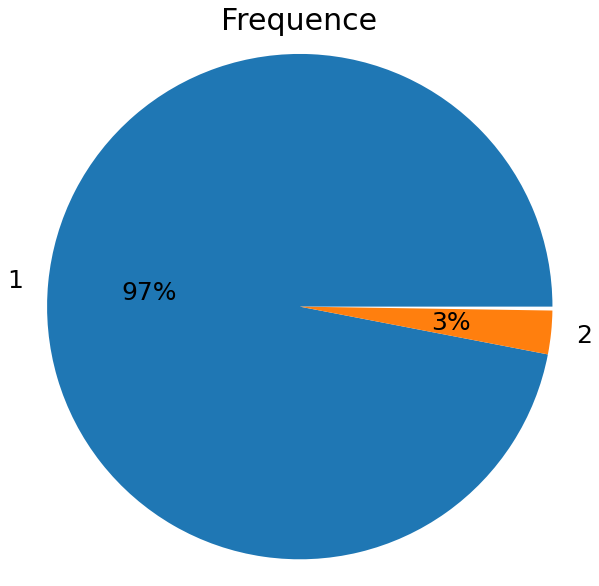

,Nb Users,% users
1,91851,96.971073
2,2635,2.781883
3,186,0.196368
4,29,0.030617
5,9,0.009502
6,5,0.005279
7,3,0.003167
16,1,0.001056
9,1,0.001056


In [45]:
pie(RFM_subset, 'Frequence', lim = 0.02)

Méthodes de scaling : 

 - MinMaxScaler
 - Normalize
 - StandardScaler

In [46]:
#MinMaxScaler
scaler = MinMaxScaler()
RFM_MinMax = pd.DataFrame(data = scaler.fit_transform(RFM_subset), 
                          columns = RFM_subset.columns, index = RFM_subset.index)
RFM_MinMax.to_csv('RFM_MinMax.csv')

RFM_scaled_time = pd.concat([RFM_MinMax,data['order_purchase_timestamp']], axis = 1)
RFM_scaled_time.to_csv('RFM_scaled_time.csv')

In [47]:
#StandardScaler
scaler = StandardScaler()
RFM_StandScal = pd.DataFrame(data = scaler.fit_transform(RFM_subset),
                             columns = RFM_subset.columns, index = RFM_subset.index)
RFM_StandScal.to_csv('RFM_StandScal.csv')

## <a class="anchor" id="section_3_2">2. Subset ++</a> 

Possibilité de rajouter des variables : 

 - le nombre d'article moyen,
 - la note moyenne de satisfaction,
 - le nombre moyen de jours entre chaque commande,
 - le panier moyen

In [48]:
subset_plus = data[['Recence', 'Frequence', 'Montant', 'Average_nb_items', 'Total_nb_items', 'Review_score',
                    'Days_bet_orders', 'Average_Basket']]

Regardons si certaines variables ne sont aps fortément corrélées et donc redondantes. 

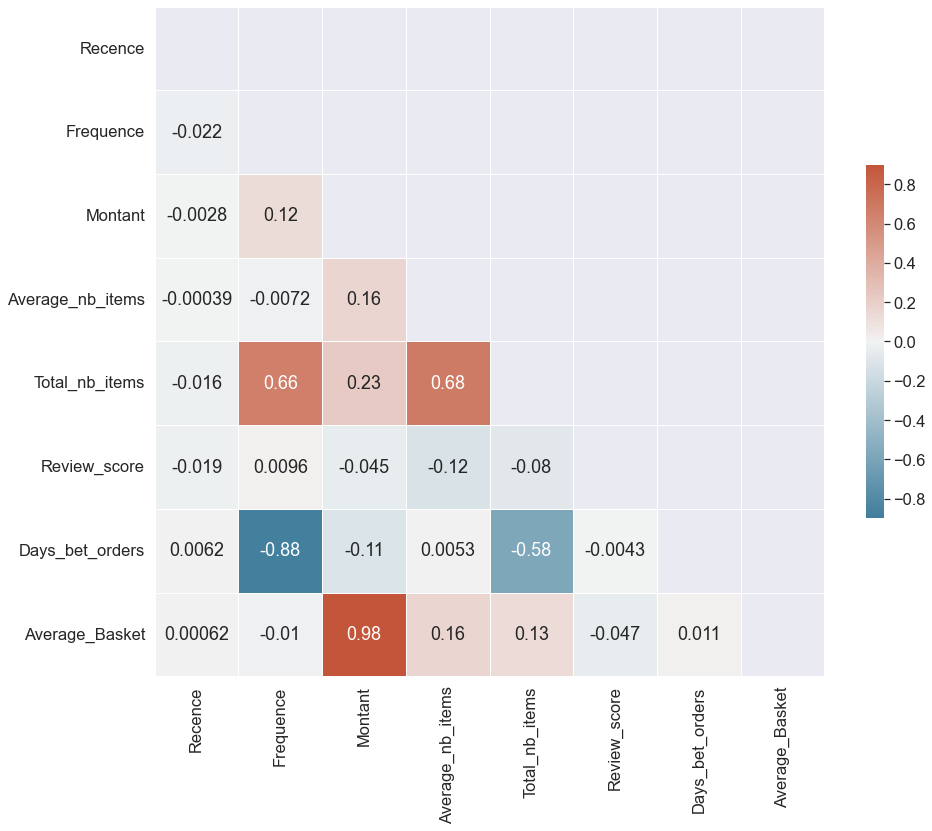

In [49]:
corr = correlation(subset_plus)

Certaines variables quantitative semblent corrélées plus fortement à d'autres.  

Effectuons des tests statistiques pour tester la significativité des valeurs du coefficient de Pearson. Posons les hypothèses :

 - H0 : Variables indépendantes si p-value > a%
 - H1 : Variables non indépendantes si p-value < a%

On choisira a = 5 par défaut.

Calculons maintenant les p-values.

In [50]:
seuil_corr = 0.6
a = 0.05
corr_pd = []
for col in corr:
    for row in corr:
        corr_ = corr.loc[row,col]
        if corr_ not in corr_pd:
            if (abs(corr_) > seuil_corr) & (corr_ < 1):
                corr_pd.append(corr_)
                p_value = pearsonr(subset_plus[row], subset_plus[col])[1]
                if p_value < a:
                    print('Les variables', '\033[1m' + row + '\033[0m','et', '\033[1m' + col +'\033[0m',
                          'sont corrélées (', round(corr_, 2), '), la p_value étant de', round(p_value, 5), '.')

Les variables Total_nb_items et Frequence sont corrélées ( 0.66 ), la p_value étant de 0.0 .
Les variables Days_bet_orders et Frequence sont corrélées ( -0.88 ), la p_value étant de 0.0 .
Les variables Average_Basket et Montant sont corrélées ( 0.98 ), la p_value étant de 0.0 .
Les variables Total_nb_items et Average_nb_items sont corrélées ( 0.68 ), la p_value étant de 0.0 .


Les variables Days_bet_orders et Average_Basket sont corrélées et anti-corrélées à Fréquence et Montant, les utiliser serait donc redondant, et sont écartées. Total_nb_items est corrélée à Average_nb_items, on ne gardera uniquement que Average_nb_items.

In [51]:
subset_plus = subset_plus.drop(['Days_bet_orders', 'Average_Basket', 'Total_nb_items'], axis = 1)
subset_plus.to_csv('Plus_subset.csv')
#subset_plus

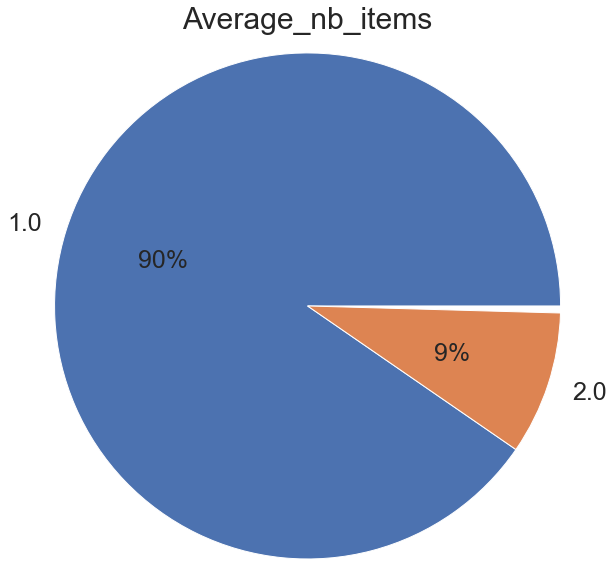

,Nb Users,% users
1.0,85623,90.395904
2.0,8677,9.160684
4.0,200,0.211149
3.0,196,0.206926
6.0,14,0.014780
5.0,4,0.004223
8.0,3,0.003167
7.0,1,0.001056
10.0,1,0.001056
11.0,1,0.001056


In [52]:
pie(subset_plus, 'Average_nb_items', lim = 0.01)

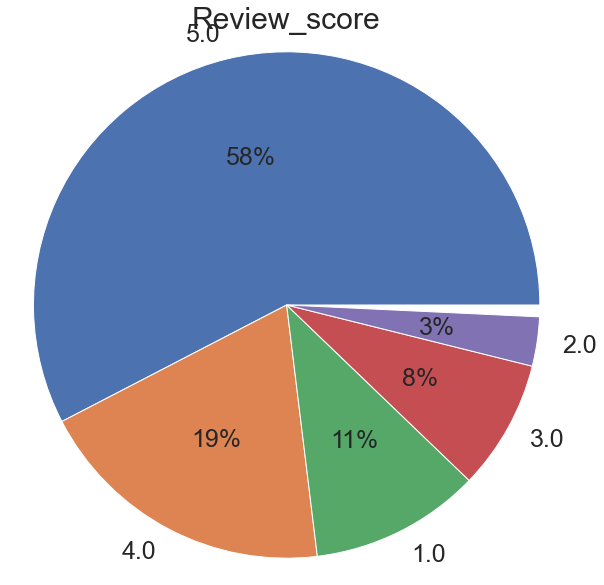

,Nb Users,% users
5.0,54569,57.610853
4.0,18303,19.323269
1.0,10305,10.879434
3.0,7861,8.299198
2.0,2975,3.140836
4.5,302,0.318834
3.5,160,0.168919
2.5,91,0.096073
4.8,20,0.021115
4.7,20,0.021115


In [53]:
pie(subset_plus, 'Review_score', lim = 0.005)

In [56]:
#MinMaxScaler
scaler = MinMaxScaler()
Plus_MinMax = pd.DataFrame(data = scaler.fit_transform(subset_plus), 
                           columns = subset_plus.columns, index = subset_plus.index)
Plus_MinMax.to_csv('Plus_MinMax.csv')
#Plus_MinMax

,Recence,Frequence,Montant,Average_nb_items,Review_score
ff22e30958c13ffe219db7d711e8f564,0.000000,0.066667,0.023679,0.0,0.00
24ac2b4327e25baf39f2119e4228976a,0.006868,0.000000,0.006164,0.0,1.00
b701bebbdf478f5500348f03aff62121,0.006868,0.000000,0.001731,0.0,0.50
7febafa06d9d8f232a900a2937f04338,0.006868,0.000000,0.003786,0.0,1.00
5c58de6fb80e93396e2f35642666b693,0.006868,0.000000,0.036718,0.1,1.00
...,...,...,...,...,...
b8b8726af116a5cfb35b0315ecef9172,0.960165,0.000000,0.001906,0.0,0.00
2f64e403852e6893ae37485d5fcacdaf,0.961538,0.000000,0.002160,0.0,0.75
0eb1ee9dba87f5b36b4613a65074337c,0.961538,0.000000,0.007305,0.0,0.00
4854e9b3feff728c13ee5fc7d1547e92,1.000000,0.000000,0.004795,0.0,0.00


In [55]:
#StandardScaler
scaler = StandardScaler()
Plus_StandScal = pd.DataFrame(data = scaler.fit_transform(subset_plus),
                              columns = subset_plus.columns, index = subset_plus.index)
Plus_StandScal.to_csv('Plus_StandScal.csv')
#Plus_StandScal